In [1]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch_ema

# import torchvision
# import torchvision.transforms as transforms

# import numpy as np
# import random

# import matplotlib.pyplot as plt
# from tqdm.auto import tqdm
# from torch.utils.data import DataLoader, Dataset

# from bfn.bfn_discrete import VanillaBFNDiscrete
# from models.unet_improved import UNetModel

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/krisztina/Documents/MLMI/Advanced_ML/BayesianFlowNetworks/')
from trainer import DiscreteBFNTrainer
trainer = DiscreteBFNTrainer(wandb_project_name=None, device='cpu')


In [2]:
#trainer.train()

In [ ]:
# input x: torch.Size([32, 1, 28, 28])
# falttened x: torch.Size([32, 784])
# x.dtype: torch.int64
# x: torch.Size([32, 784])
# e_x: torch.Size([32, 784, 2])
# beta: torch.Size([32, 784, 1])
# y shape: torch.Size([32, 784, 2])
# theta shape: torch.Size([32, 784, 2])
# t shape: torch.Size([32, 784])
# FourierIIA img.shape torch.Size([32, 784, 1])
# FourierIIA img.shape torch.Size([32, 28, 28, 1])
# FourierIIA t.shape torch.Size([32, 784, 1])
# flat_img.shape torch.Size([32, 784, 1])
# flat_t.shape torch.Size([32, 784, 1])
# t_feats.shape torch.Size([32, 784, 1])
# all_feat_list[0].shape torch.Size([32, 784, 1])
# all_feat_list[1].shape torch.Size([32, 784, 1])
#  model output shape: torch.Size([32, 784, 1])
# p_output or e_hat shape: torch.Size([32, 784, 2])
# e_x shape: torch.Size([32, 784, 2])
# t shape: torch.Size([32, 784])

28.0

In [ ]:
# import torch
# input_shape = [28, 28]
# input_channels = 1
# img = torch.randn((32, 784, 1))
# img = img.reshape(-1, *input_shape, input_channels)
# print(img.shape)

784

In [ ]:
import torch
from datasets.utils import get_image_grid_from_tensor
model = trainer.bfn_model
model.eval()

# Generate samples and priors
samples, priors = model.sample_generation_for_discretised_data(n_steps=5)
samples = samples.to(torch.float32)


In [ ]:
DATAPATH = "./data/"
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_MODEL = True
MODELS_PATH = "./models/"

/home/krisztina/Documents/MLMI/Advanced_ML/BayesianFlowNetworks/.conda/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

In [ ]:
def get_sample(dataloader: torch.utils.data.DataLoader) -> tuple[torch.Tensor, int]:
    """
    Returns a random sample from a data loader

    Args:
        dataloader (torch.utils.data.DataLoader): data loader storing the images.

    Returns:
        tuple[torch.Tensor, int]: (image, label)
    """
    for sample in dataloader:
        return sample[0], sample[1][0].numpy()
    raise IndexError("Could not sample an empty data loader.")
    
def show_samples(dataloader: torch.utils.data.DataLoader, n: int, title: str=None) -> None:
    """
    Displays some random samples from a data loader.

    Args:
        dataloader (torch.utils.data.DataLoader): data loader storing the images.
        n (int): number of samples to display.
    """
    fig, ax = plt.subplots(1, n, figsize=(3*n, 3))
    for i in range(n):
        img, label = get_sample(dataloader)
        ax[i].imshow(img[0][0], cmap='Greys_r', interpolation='nearest')
        ax[i].set_title(label)
        ax[i].axis("off")
    title = title if title else f"{n} random samples"
    fig.suptitle(title, position=(0.5, 1.1))
    
def moving_average(data: list[float], window_size: int=20) -> list[float]:
    """
    Computes the moving average of a list of values.

    Args:
        data (list[float]): list of values.
        window_size (int, optional): length of the window over which the values will be averaged out. Defaults to 20.

    Returns:
        list[float]: list of averaged values.
    """
    moving_avg = []
    for i in range(len(data) - window_size + 1):
        window = data[i : i + window_size]
        avg = sum(window) / window_size
        moving_avg.append(avg)
    return moving_avg

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.Normalize((0.5,), (0.5,)) # normalize pixel values to [-1, 1]
])

#download and load the MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root=DATAPATH, train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root=DATAPATH, train=False, download=True, transform=transform)

#create data loaders
batch_size=64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:05<00:00, 1698644.40it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 28263111.02it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 1653096.94it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6955286.15it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class DynamicallyBinarizedMNIST(torchvision.datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super(DynamicallyBinarizedMNIST, self).__init__(root, train=train, transform=transform,
                                                        target_transform=target_transform, download=download)

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        if self.transform is not None:
            img = self.transform(img)
        return img, target

def collate_dynamic_binarize(batch: list[tuple[torch.Tensor, int]]) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Collate function that samples a binarization probability for each batch.

    Args:
        batch (list[tuple[torch.Tensor, int]]): list of samples to collate.

    Returns:
        tuple[torch.Tensor, torch.Tensor]: resulting batch.
    """
    images, targets = zip(*batch)
    binarization_probs = torch.rand(len(images))
    binarized_images = []
    for img, prob in zip(images, binarization_probs):
        binarized_img = (img > prob).float()
        binarized_images.append(binarized_img)
    return torch.stack(binarized_images)[:, None, ...].to(torch.int64), torch.tensor(targets)

# Create the dynamically binarized MNIST dataset
train_dataset = DynamicallyBinarizedMNIST(root=DATAPATH, train=True, download=True) # transform=transform
test_dataset = DynamicallyBinarizedMNIST(root=DATAPATH, train=False, download=True) # transform=transform

# Create data loaders with the collate function
batch_size = 512
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_dynamic_binarize)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_dynamic_binarize)

Number of data points in the training dataset: 118
Number of data points in the training dataset: 20


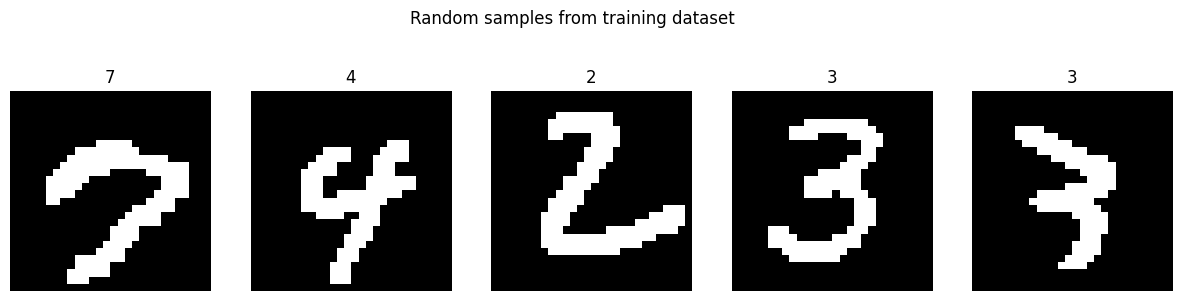

In [ ]:
print(f"Number of data points in the training dataset: {len(train_loader)}")
print(f"Number of data points in the training dataset: {len(test_loader)}")
show_samples(train_loader, 5, "Random samples from training dataset")

In [ ]:
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np



def idx_to_float(idx: np.ndarray, num_bins: int):
    flt_zero_one = (idx + 0.5) / num_bins
    return (2.0 * flt_zero_one) - 1.0

def float_to_idx(flt: np.ndarray, num_bins: int):
    flt_zero_one = (flt / 2.0) + 0.5
    return torch.clamp(torch.floor(flt_zero_one * num_bins), min=0, max=num_bins - 1).long()

def quantize(flt, num_bins: int):
    return idx_to_float(float_to_idx(flt, num_bins), num_bins)


def rgb_image_transform(x, num_bins=256):
    return quantize((x * 2) - 1, num_bins).permute(1, 2, 0).contiguous()

def get_image_grid_from_tensor(image_tensor, nrows=1):
    return make_grid(image_tensor, nrow=nrows, normalize=True)

class CIFAR10(torchvision.datasets.CIFAR10):
    def __getitem__(self, idx):
        return super().__getitem__(idx)[0]
    
def get_standard_transform(num_bins, train=True):
    return transforms.Compose([transforms.ToTensor(),
                            transforms.RandomHorizontalFlip() if train else nn.Identity(),
                            transforms.Lambda(lambda x: rgb_image_transform(x, num_bins)),])

def get_cifar10_datasets(num_bins:int = 16, root='./datasets/') -> tuple[Dataset, Dataset, Dataset]:
    # create datasets, train and val are the same (apart from transform), test is official cifar10 test set
    train_set = CIFAR10(root=root, train=True, download=True, transform=get_standard_transform(num_bins, train=True))
    val_set = CIFAR10(root=root, train=True, download=True, transform=get_standard_transform(num_bins, train=False))
    test_set = CIFAR10(root=root, train=False, download=True, transform=get_standard_transform(num_bins, train=False))
    return train_set, val_set, test_set

def get_cifar10_dataloaders(batch_size:int = 32, num_bins:int = 16, valid_size=0.01, seed=7) -> tuple[DataLoader, DataLoader, DataLoader]:

    # get datasets
    train_set, val_set, test_set = get_cifar10_datasets(num_bins)

    # train and val are the same by default, split them up using SubsetRandomSampler
    indices = list(range(len(train_set)))
    split = int(valid_size*len(train_set))
    np.random.seed(seed)
    np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # create dataloaders, using samplers
    train_loader = DataLoader(train_set, sampler=train_sampler, batch_size=batch_size, drop_last=True)
    val_loader = DataLoader(val_set, sampler=valid_sampler, batch_size=batch_size)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

In [ ]:
# class MNIST(torchvision.datasets.MNIST):
#     def __getitem__(self, idx):
#         return super().__getitem__(idx)[0]

# def bin_mnist_transform(x):
#     return torch.bernoulli(x.permute(1, 2, 0).contiguous()).int()

# transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(bin_mnist_transform)])
# train_set = MNIST(root=DATAPATH, train=True, download=True, transform=transform)
# val_set = MNIST(root=DATAPATH, train=True, download=True, transform=transform)
# test_set = MNIST(root=DATAPATH, train=False, download=True, transform=transform)

# batch_size = 512
# train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)#, collate_fn=collate_dynamic_binarize)
# test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)#, collate_fn=collate_dynamic_binarize)

In [1]:
# print(f"Number of data points in the training dataset: {len(train_loader)}")
# print(f"Number of data points in the training dataset: {len(test_loader)}")
# show_samples(train_loader, 5, "Random samples from training dataset")